In [6]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
PROCESSED_DATA = os.path.join(ROOT_DIR, 'data/processed')
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')
sys.path.append(ROOT_DIR)  # To find local version of the library

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import helper as hp
import skimage.transform as st
import helper as hp
import random

from models.maskrcnn.mrcnn import visualize,utils

IMG_DIR = os.path.join(PROCESSED_DATA, 'images')
LBL_DIR = os.path.join(PROCESSED_DATA, 'segmentations')


keeplabels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}
inv_keeplabels =  {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}

# Labeling IOUs

Ignroe this mor now
```for all 3277 pics
for all class, generate each instances of mask
    taken care of with the polygon json processing
for each mask, label them 
    id_class_instance-num e.g.
        aachen_000003_000019_sidewalk_001
        aachen_000003_000019_car_001
        ...
    if there are 10 labels: 3 of them sidewalk and 7 of them not sidewalk
        the data for the classifer will be something like
          img-id_sidewalk_instance-id   |   img-id_class_instance-id   |   IOU (not read but calculated)    |  label
```


In [2]:
# reading label data
df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels.csv'),index_col=None)
df.head()
data = df.set_index('ID').T.to_dict('list')
for k in data:
    data[k] = [i.split(' ')[:-1] for i in data[k]][0]
    data[k] = np.array([int(i) for i in data[k]])

In [3]:
# reading sample data
txt = os.path.join(ROOT_DIR, 'data/processed/sample.txt')
with open(txt) as f:
    sample_ids= f.readlines()

# all the image ids
sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]

# all instance labels for each id
sample_labels = [data[id] for id in sample_ids]


# {img_id: all_instance_mask}
data_mask = {}
for id in sample_ids:
    masks = hp.stack_mask(id, data,(256,512))
    data_mask[id] = masks
    # np.save(os.path.join(PROCESSED_DATA,'masks',f'{id}.npy'),masks)

95

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


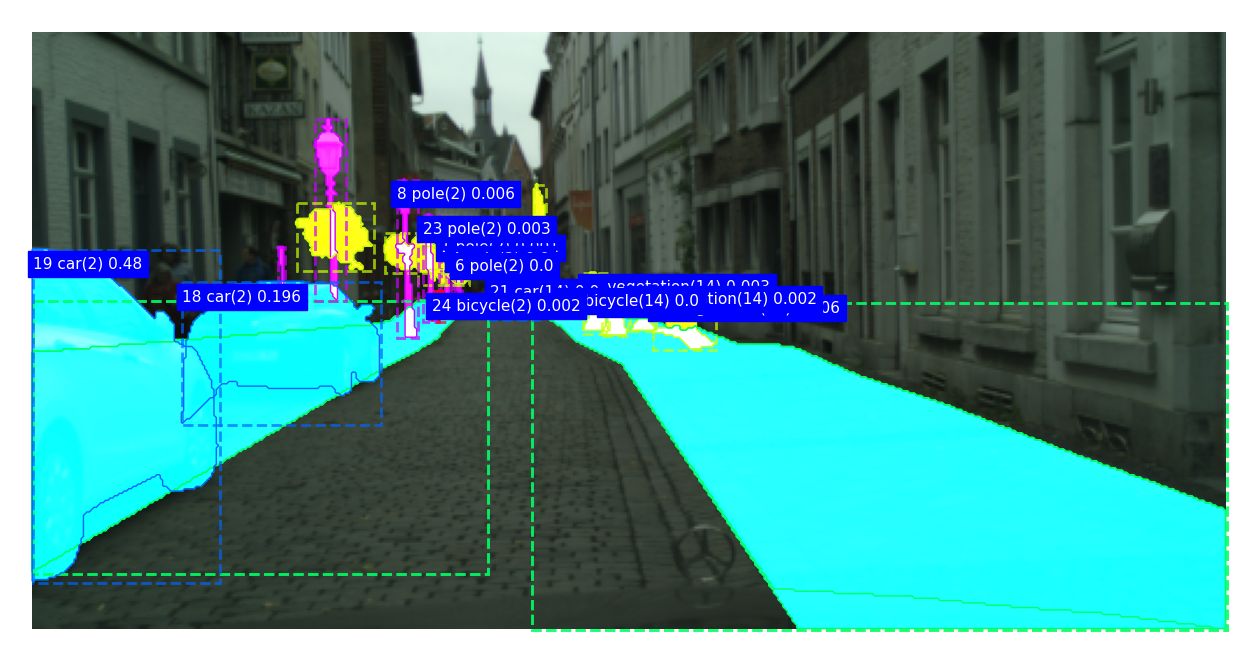

In [8]:

i = random.randint(0,len(sample_ids))
dim = (256,512)
labels_dict = {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}


# get the mask and label of this specific i
mask = data_mask[sample_ids[i]]
labels = sample_labels[i]
names = [labels_dict[y]for y in labels] #label in plain english


# read the image from directory and resize it
img = plt.imread(f'{IMG_DIR}/{sample_ids[i]}.png')
img = st.resize(img, dim)

# extract all the bounding boxes 
bboxes= utils.extract_bboxes(mask)
bboxes_w_ids = np.zeros((bboxes.shape[0],bboxes.shape[1]+1))


ious = hp.generate_ious(labels, mask)
captions = hp.generate_captions_obstructed(labels, ious)

visualize.display_instances(img,bboxes,mask,labels,labels_dict, captions=captions)


should i create a csv of bounding boxes? separately?
img-id_sidewalk_instance-id   |   img-id_class_instance-id   |   IOU (not read but calculated)    |  label